$\textbf{Project 20: Machine learning with Monte-Carlo data for the 2D classical Ising model (Monte-Carlo + Machine Learning)}$


Generate some Monte-Carlo spin configurations of the 2D square lattice Ising model at two different temperatures (above and below the critical temperature), and use them to train a neural network. Then use this network and study the output for different temperatures, how good are the predicted temperatures? How do your results depend on
the system size?

We will use slightly modified data-generating functions from the seminar. We use 1.5K and 3.0K for training our networks.

In [1]:
''' 
We will use slightly modified data-generating functions from the tutorial. 
We use temperatures 1.5 and 3.0 for training our networks.
The data is generated in MNIST format as three data sets.
'''

import numpy as np
import scipy
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
import pickle
import gzip

# Swensen-Wang algorithm for the Ising model (see ex. 2)

def init_system(Lx, Ly):
    #Determine the bond array and an initial state of spins
    N = Lx * Ly

    def xy_2_idx(x, y):
        return x*Ly + y

    def idx_2_xy(n):
        return n // Ly, np.mod(n, Ly)

    bonds = []
    for x in range(Lx):
        for y in range(Ly):
            n = xy_2_idx(x, y)
            m1 = xy_2_idx((x+1)% Lx, y)
            m2 = xy_2_idx(x, (y+1) % Ly)
            bonds.append([n, m1])
            bonds.append([n, m2])
    bonds = np.array(bonds)
    spins = np.random.randint(0, 2, size=(N,))*2 - 1
    return spins, bonds, N

def get_weights(spins, bonds, T):
    weights = np.zeros(len(bonds))
    p = np.exp(-2./T)  # set J = 1
    for b in range(len(bonds)):
        n = bonds[b, 0]
        m = bonds[b, 1]
        if spins[n] == spins[m] and np.random.rand() > p:
            weights[b] = 1.
    return weights

def flip_spins(spins, N_components, labels):
    flip_cluster = np.random.random(N_components) < 0.5   # N_components True/False values with 50/50 chance
    for n in range(len(spins)):
        cluster = labels[n]
        if flip_cluster[cluster]:
            spins[n] = - spins[n]

def swendsen_wang_update(spins, bonds, T):
    #Perform one update of the Swendsen-Wang algorithm
    N = len(spins)
    weights = get_weights(spins, bonds, T)
    graph = csr_matrix((weights, (bonds[:, 0], bonds[:, 1])), shape=(N, N))
    graph += csr_matrix((weights, (bonds[:, 1], bonds[:, 0])), shape=(N, N))
    N_components, labels = connected_components(graph, directed=False)
    flip_spins(spins, N_components, labels)

try:
    # Try to speed things up using just-in-time compilation from the numba package, if available
    from numba import jit
    get_weights = jit(get_weights, nopython=True)
    flip_spins = jit(flip_spins, nopython=True)
except ImportError:
    print("warning: can't import numba: code will run slower (~3 minutes), but still works")
    pass

def generate_data(L=28, temps=[3., 1.5], N_training=10000):
    '''
    Monte Carlo for two different temperatures.

    Return the configurations in the same data format as the MNIST data set, namely images and labels:
    training_data, validation_data, test_data.
    '''
    
    spins, bonds, _ = init_system(L, L)
    N_val = N_test = N_training // 5
    # generate the data
    imgs = [[], [], []] #three sets: train, validate, test 
    labels = [[], [], []] #arrays of labels for each set
    for lbl, T in enumerate(temps):
        print("generate data for T= {T:.3f}".format(T=T), flush=True)
        for _ in range(50):
            swendsen_wang_update(spins, bonds, T)
        for i, N in enumerate([N_training, N_val, N_test]):
            for _ in range(N):
                swendsen_wang_update(spins, bonds, T)
                imgs[i].append(spins.copy())
                labels[i].append(T)
    # shuffle the data and bring it in the same form as the MNIST data set
    for i in range(3):
        new_order = np.arange(len(imgs[i]), dtype=np.intp)
        np.random.shuffle(new_order)
        imgs[i] = np.array(imgs[i])[new_order, :]
        labels[i] = np.array(labels[i])[new_order] #[labels[i] for i in new_order]
    training_data = imgs[0], labels[0]
    validation_data = imgs[1], labels[1]
    test_data = imgs[2], labels[2]
    return training_data, validation_data, test_data

def save_data(data, filename):
    print("save data to ", filename)
    with gzip.open(filename, 'wb', compresslevel=2) as f:
        pickle.dump(data, f)

In [2]:
! pip install pytorch-lightning --quiet
import pytorch_lightning as pl
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

     |████████████████████████████████| 700 kB 16.9 MB/s 
     |████████████████████████████████| 5.8 MB 45.0 MB/s 
     |████████████████████████████████| 419 kB 55.4 MB/s 
     |████████████████████████████████| 596 kB 10.6 MB/s 
     |████████████████████████████████| 141 kB 49.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.9.1 which is incompatible.


Let's define the models we will use: a fully connected, and a convolutional one.

In [3]:
'''
Let's define the models we will use: a fully connected (dense), and a convolutional one
'''
class IsingDataset(Dataset):
    def __init__(self, xs, ys, L=28):
        self.xs = xs
        self.ys = ys
        self.L = L

    def __len__(self):
        return len(self.ys)
    
    def __getitem__(self, idx):
        # return data in pytorch suitable format for black and white pictures: shape (1, 28, 28)
        return self.xs[idx].reshape((self.L, self.L))[None].astype(np.float32), self.ys[idx][None]


def step(self, batch, batch_idx, mode):
    # a function of a step returning loss 
    x, y = batch
    #predictions of network
    preds = self(x)
    #loss function
    loss = F.l1_loss(preds, y)
    log = mode == 'train'
    if log:
        self.log(mode + '_loss', loss, on_step=log, on_epoch=log, logger=log)
    else:
        self.log(mode + '_loss', loss, prog_bar=~log)
    return loss

class DenseModel(pl.LightningModule):
    #simple model without convolutions
    def __init__(self, input_shape, lr=1e-4):
        super().__init__()

        self.save_hyperparameters()
        self.learning_rate = lr
        
        #take 3 linear layers of neurons
        self.d1 = nn.Linear(input_shape[-1] * input_shape[-2], 256)
        self.d2 = nn.Linear(256, 64)
        self.d3 = nn.Linear(64, 1)

    def forward(self, x):
        # matrix to vector
        x = x.view(x.size(0), -1)
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        x = F.relu(self.d3(x))
        return x

    def training_step(self, batch, batch_idx):
        return step(self, batch, batch_idx, 'train')
    
    def validation_step(self, batch, batch_idx):
        return step(self, batch, batch_idx, 'val')
    
    def test_step(self, batch, batch_idx):
        return step(self, batch, batch_idx, 'test')
    
    def configure_optimizers(self):
        # choose an algorithm of optimization for gradient descent
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


class ConvModel(DenseModel):
    # a model with convolutions
    def __init__(self, input_shape, learning_rate=1e-4):
        super().__init__(input_shape, learning_rate)
        
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        
        #convolutional and pooling layers
        self.c1 = nn.Conv2d(input_shape[0], 16, 3, 1)
        self.c2 = nn.Conv2d(16, 32, 3, 1)
        self.c3 = nn.Conv2d(32, 64, 3, 1)
        self.p1 = torch.nn.MaxPool2d(2)
        self.p2 = torch.nn.MaxPool2d(2)

        #we propagate a random tensor through a convolutional part of the network to see the dimension of input for linear part
        input = torch.autograd.Variable(torch.rand(1, *input_shape))
        output_feat = self._conv_forward(input) 
        features = output_feat.data.view(1, -1).size(1)
        
        self.d1 = nn.Linear(features, 256)
        self.d2 = nn.Linear(256, 64)
        self.d3 = nn.Linear(64, 1)

    def _conv_forward(self, x):
        x = F.relu(self.c1(x))
        #pooling layers forfaster shape decrease
        x = self.p1(F.relu(self.c2(x)))
        x = self.p2(F.relu(self.c3(x)))
        return x

    def _dense_forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        x = F.relu(self.d3(x))
        return x

    def forward(self, x):
        x = self._conv_forward(x)
        x = self._dense_forward(x)
        return x

def train_model(model, epochs, batch_size, data, L):
    # batch size = number of datapairs for a single gradient step
    # epoch = a full go-through all training data
    train_dataloader = DataLoader(IsingDataset(*data[0], L), batch_size=batch_size)
    val_dataloader = DataLoader(IsingDataset(*data[1], L), batch_size=batch_size)
    test_dataloader = DataLoader(IsingDataset(*data[2], L), batch_size=batch_size)

    # initialize the trainer on the data 
    trainer = pl.Trainer(max_epochs=epochs, gpus=1)
    # train
    trainer.fit(model, train_dataloader, val_dataloader)
    # save the result of a test
    res = trainer.test(dataloaders=test_dataloader)

    # drawing of configurations of tests with real and predicted temps
    images, labels = next(iter(test_dataloader))
    preds = model(images)
    preds = [l[0].detach().cpu().numpy() for l in preds]
    labels = [l[0].detach().cpu().numpy() for l in labels]
    images = [im[0].detach().cpu().numpy() for im in images]

    w = 10
    h = 10
    fig = plt.figure(figsize=(8, 8))
    columns = 3
    rows = 3
    for i in range(1, columns*rows +1):
        img = images[i-1]
        fig.add_subplot(rows, columns, i)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'pred {int(preds[i-1] * 100) / 100}, real {labels[i-1]}')
        plt.imshow(img, cmap='gray')
    plt.show()
    return res

Now let's train both of the models on lattices of different sizes (e.g. L = 28 and 56) and evaluate the quality py predicting temperatures not present in training data (anything but 1.5 and 3.0).

In [4]:
'''
Now train both of the models on lattices of different sizes (e.g. 28 and 56)
and evaluate the quality by predicting temperatures not present in training data 
(anything but 1.5 and 3.0)
'''
Ls = [28, 56]
test_results = {k: {'dense': [], 'conv': []} for k in Ls}

generate data for T= 3.000
generate data for T= 1.500
generate data for T= 0.500
generate data for T= 1.000
generate data for T= 1.500
generate data for T= 2.000
generate data for T= 2.500
generate data for T= 3.000
generate data for T= 3.500


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | d1   | Linear | 200 K 
1 | d2   | Linear | 16.4 K
2 | d3   | Linear | 65    
--------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.870     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1389: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  + f" You can pass `.{fn}(ckpt_path='best')` to use the best model or"
Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=4-step=11115.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=4-step=11115.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4505465626716614
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


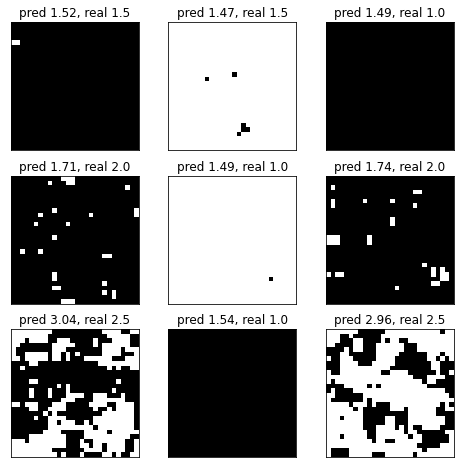

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type      | Params
-----------------------------------
0 | d1   | Linear    | 409 K 
1 | d2   | Linear    | 16.4 K
2 | d3   | Linear    | 65    
3 | c1   | Conv2d    | 160   
4 | c2   | Conv2d    | 4.6 K 
5 | c3   | Conv2d    | 18.5 K
6 | p1   | MaxPool2d | 0     
7 | p2   | MaxPool2d | 0     
-----------------------------------
449 K     Trainable params
0         Non-trainable params
449 K     Total params
1.799     Total estimated mode

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
Restoring states from the checkpoint path at /content/lightning_logs/version_1/checkpoints/epoch=4-step=11115.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_1/checkpoints/epoch=4-step=11115.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3674688935279846
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


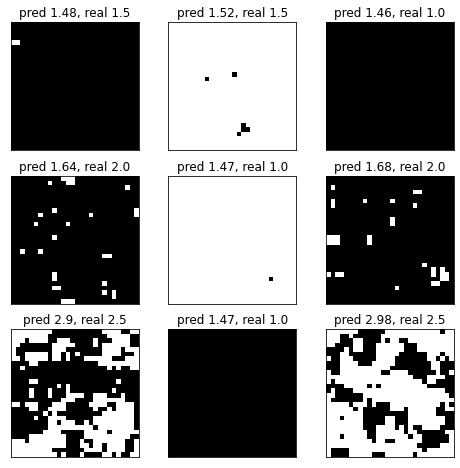

generate data for T= 3.000
generate data for T= 1.500
generate data for T= 0.500
generate data for T= 1.000
generate data for T= 1.500
generate data for T= 2.000
generate data for T= 2.500
generate data for T= 3.000
generate data for T= 3.500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | d1   | Linear | 803 K 
1 | d2   | Linear | 16.4 K
2 | d3   | Linear | 65    
--------------------------------
819 K     Trainable params
0         Non-trainable params
819 K     Total params
3.278     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
Restoring states from the checkpoint path at /content/lightning_logs/version_2/checkpoints/epoch=4-step=11115.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_2/checkpoints/epoch=4-step=11115.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5931715965270996
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


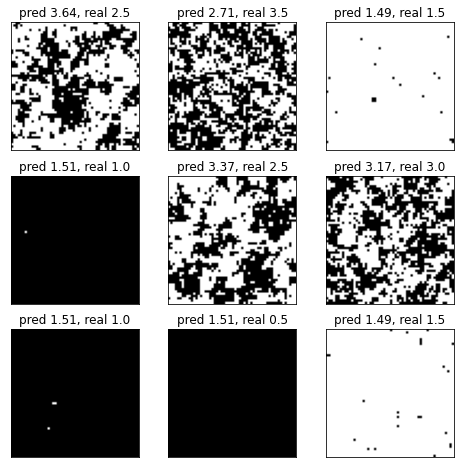

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type      | Params
-----------------------------------
0 | d1   | Linear    | 2.4 M 
1 | d2   | Linear    | 16.4 K
2 | d3   | Linear    | 65    
3 | c1   | Conv2d    | 160   
4 | c2   | Conv2d    | 4.6 K 
5 | c3   | Conv2d    | 18.5 K
6 | p1   | MaxPool2d | 0     
7 | p2   | MaxPool2d | 0     
-----------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.597     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
Restoring states from the checkpoint path at /content/lightning_logs/version_3/checkpoints/epoch=4-step=11115.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_3/checkpoints/epoch=4-step=11115.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.36359280347824097
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


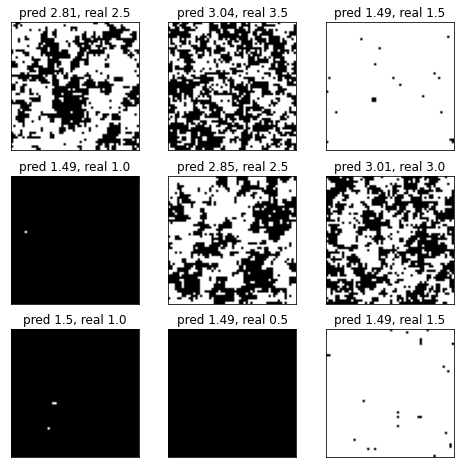

In [5]:
epochs = 5
batch_size = 9

for L in Ls:
    data = generate_data(L)
    test_data = generate_data(L, np.arange(1, 8) / 2)
    data = (data[0], data[1], test_data[-1])

    model = DenseModel((1, L, L))
    res = train_model(model, epochs, batch_size, data, L)
    test_results[L]['dense'].append(res[0]['test_loss'])

    model = ConvModel((1, L, L))
    res = train_model(model, epochs, batch_size, data, L)
    test_results[L]['conv'].append(res[0]['test_loss'])

In [6]:
test_results

{28: {'conv': [0.3674688935279846], 'dense': [0.4505465626716614]},
 56: {'conv': [0.36359280347824097], 'dense': [0.5931715965270996]}}

## Seems like convolutional nets better work on larger lattices while dense networks on smaller ones. That could be explined by the architeectural diferences. Let's now take the best model (convolutional on L=56) and see what temperatures it predicts

In [7]:
model.eval()
d = {k: [] for k in (np.arange(1, 8) / 2)}
for i in range(len(data[-1][0])):
    im = data[-1][0][i].reshape([56, 56])[None][None]
    label = data[-1][1][i]
    pred = float(model(torch.Tensor(im))[0][0].detach().cpu().numpy())
    d[label].append(pred)

In [8]:
graph = {k: (np.array(v).mean(), np.array(v).std()) for k, v in d.items()}

Text(0, 0.5, 'predicted temperature')

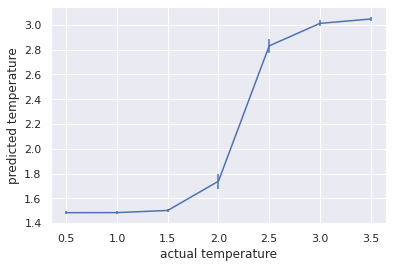

In [9]:
import seaborn as sns
sns.set()
plt.errorbar(list(graph.keys()), [v[0] for v in graph.values()], [v[1] for v in graph.values()])
plt.xlabel('actual temperature')
plt.ylabel('predicted temperature')

The resulting graph resembles a sigmoid function, which goes through (1.5, 1.5) and (3.0, 3.0) coordinates, yet predicts wrong temperatures in other points.